In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_bars_heights(x, clus):
    counts = np.sum(clus == x[:, np.newaxis], axis=1)
    return counts / np.sum(counts)

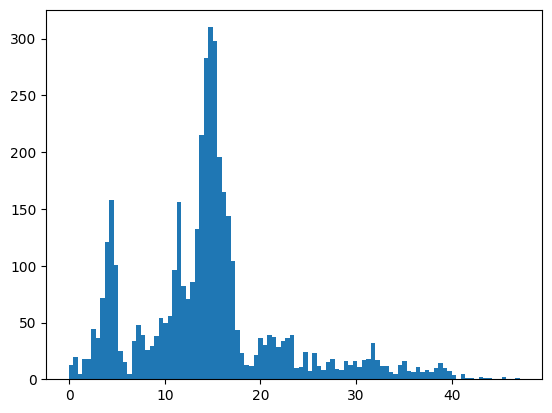

In [3]:
data = np.loadtxt("data/shapley.csv", skiprows=1)
plt.hist(data, bins=100)
plt.show()

In [4]:
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.stats import gaussian_kde

from scipy.signal import argrelextrema

grid = np.linspace(0, 40, 500)
dists = np.sort(pairwise_distances(data.reshape(-1, 1)).reshape(-1,))
kde_dens = gaussian_kde(dists)
eval_dens = kde_dens.pdf(grid)
argmins = argrelextrema(eval_dens, np.less)[0]

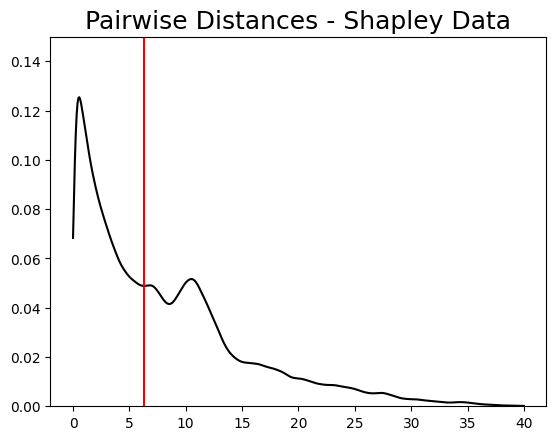

In [5]:
plt.plot(grid, eval_dens, color="k")
plt.vlines(grid[argmins[0]], ymin=0, ymax=1, color="r")
plt.ylim((0, 0.15))
plt.title("Pairwise Distances - Shapley Data", fontsize=18)
plt.savefig("shapley_distances.pdf", bbox_inches="tight")

# Traditional Mixture Models

In [19]:
from bayesmixpy import run_mcmc, build_bayesmix

build_bayesmix()

Building the Bayesmix executable
CMAKE_MODULE_PATH /Users/marioberaha/dev/bayesmix_origin
CMake Warning at /opt/homebrew/Cellar/cmake/3.27.6/share/cmake/Modules/Platform/Darwin-Initialize.cmake:306 (message):
Ignoring CMAKE_OSX_SYSROOT value:

/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX14.4.sdk

because the directory does not exist.
Call Stack (most recent call first):
/opt/homebrew/Cellar/cmake/3.27.6/share/cmake/Modules/CMakeSystemSpecificInitialize.cmake:34 (include)
CMakeLists.txt:27 (project)


--
-- Fetching bayesmix-dev/math
-- Populating math
CMake Warning at /opt/homebrew/Cellar/cmake/3.27.6/share/cmake/Modules/Platform/Darwin-Initialize.cmake:306 (message):
Ignoring CMAKE_OSX_SYSROOT value:

/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX14.4.sdk

because the directory does not exist.
Call Stack (most recent call first):
/opt/homebrew/Cellar/cmake/3.27.6/share/cmake/Modules/CMakeSystemSp

lib2to3.main: Output in '/Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto/' will mirror the input directory '/Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto' layout.
RefactoringTool: Skipping optional fixer: buffer
RefactoringTool: Skipping optional fixer: idioms
RefactoringTool: Skipping optional fixer: set_literal
RefactoringTool: Skipping optional fixer: ws_comma
RefactoringTool: No changes to /Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto/__init__.py
RefactoringTool: No changes to /Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto/algorithm_id_pb2.py
RefactoringTool: No changes to /Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto/algorithm_params_pb2.py
RefactoringTool: Refactored /Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto/algorithm_state_pb2.py
RefactoringTool: Refactored /Users/marioberaha/dev/bayesmix_origin/python/bayesmixpy/proto/distribution_pb2.py
RefactoringTool: No changes to /Users/m

True

In [20]:
mfm_params = """
fixed_value {
    lambda: 4.0
    gamma: 1.0
}
"""

dp_params = """
fixed_value {
  totalmass: 2.0
}
"""

g0_params = """
fixed_values {
    mean: 14.5
    var_scaling: 0.1
    shape: 2.0
    scale: 25.0
}
"""

algo_params = """
    algo_id: "Neal2"
    rng_seed: 20201124
    iterations: 10000
    burnin: 5000
    init_num_clusters: 10
"""

In [21]:
np.random.seed(20231011)

ndatas = [100, 500, 2000, len(data)]
sub_datasets = [
    np.random.choice(data, n) for n in ndatas
]

In [22]:
nclus_grid = np.arange(1, 100)
nclus_probas = []
dens_evals = []
grid = np.linspace(0, 50, 500)

for dataset in sub_datasets:
    log_dens, nc_chain, _, _, _ = run_mcmc(
        "NNIG", "DP", dataset, g0_params, dp_params, algo_params, 
        dens_grid=grid, return_clusters=False, return_num_clusters=True,
        return_best_clus=False)
    
    
    nclus_probas.append(get_bars_heights(nclus_grid, nc_chain))
    dens_evals.append(np.mean(np.exp(log_dens), axis=0))

Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, DP mixing...
[============================================================] 100% 6.449s                                                                                                                                                                                                                                                                                                                                       Done
Computing log-density...
Successfully wrote density to /var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/tmp8enc3jr5/eval_dens.csv
Successfully wrote number of clusters to /var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/tmp8enc3jr5/n_clus.csv
End of run_mcmc.cc

Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, DP mixing...
[============================================================] 100% 10.697s    

In [23]:
from matplotlib import cm

colors = cm.get_cmap("Greens")(np.linspace(0, 1,  len(ndatas) + 2))
colors = colors[2:]

/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_50678/1949101038.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Greens")(np.linspace(0, 1,  len(ndatas) + 2))


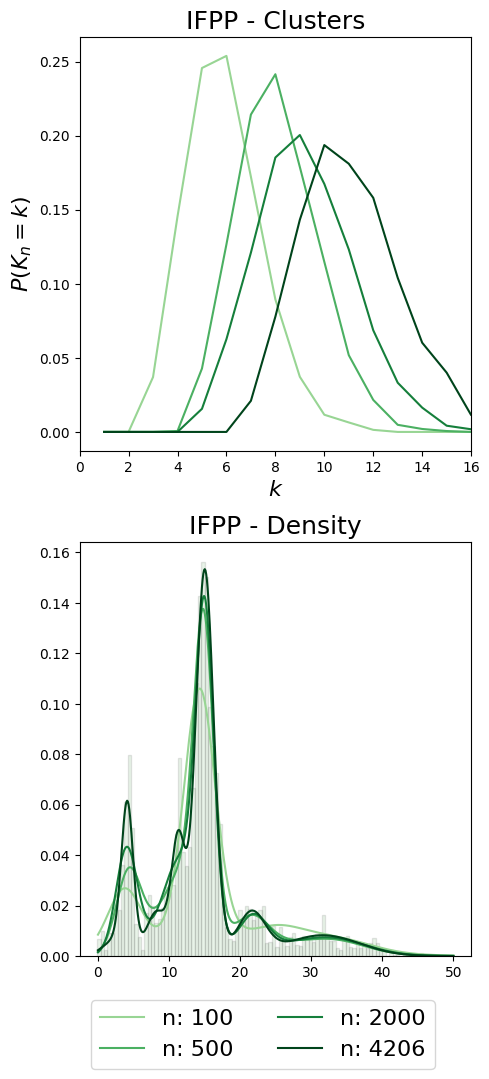

In [24]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

for i, n in enumerate(ndatas):
    axis[0].plot(nclus_grid, nclus_probas[i], color=colors[i], 
             label="n: {0}".format(n))
    axis[1].plot(grid, dens_evals[i], color=colors[i], 
             label="n: {0}".format(n))
    
axis[0].set_xlim((0, 16))
axis[0].set_xlabel(r"$k$", fontsize=16)
axis[0].set_ylabel(r"$P(K_n = k)$", fontsize=16)
axis[0].set_title(r"IFPP - Clusters", fontsize=18)

axis[1].set_title("IFPP - Density", fontsize=18)

axis[1].hist(data, bins=100, alpha=0.1, density=True, 
         histtype='bar', ec='black', color="forestgreen")

plt.tight_layout()
axis[1].legend(loc="lower left", ncol=2, fontsize=16, bbox_to_anchor=(0.0, -0.3))
plt.savefig("plots/galaxy_mfm.pdf", bbox_inches="tight")
plt.show()

# SNCP

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import sncp_algorithm as algo
from sncp_state import State, Prior

from scipy.cluster.vq import kmeans
from joblib import Parallel, delayed

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

data = np.loadtxt("data/shapley.csv", skiprows=1)

np.random.seed(20231011)

ndatas = [100, 500, 2000, len(data)]
sub_datasets = [
    np.random.choice(data, n) for n in ndatas
]

nclus_grid = np.arange(1, 100)
grid = np.linspace(0, 50, 500)


In [ ]:
prior = Prior(
    alpha = 2.5,
    big_mean = np.mean(data),
    big_var = 2.5 * np.std(data),
    gamma = 0.5,
    jump_a = 2.0,
    jump_b = 25.0,
    var_a = 2.0,
    var_b = 2.0
)

def initialize_state(dataset):
    n_atoms = 3

    alloc_atoms = np.hstack([
        kmeans(dataset, n_atoms)[0].reshape(-1, 1),
        np.ones((n_atoms, 1)) * 3])

    non_alloc_atoms = np.zeros((0, 2))
    state = State(
    iter = 0,
    clus = np.random.choice(np.arange(n_atoms), len(dataset)),
    alloc_atoms = alloc_atoms,
    non_alloc_atoms = non_alloc_atoms,
    alloc_jumps = np.ones(n_atoms),
    non_alloc_jumps = np.ones(len(non_alloc_atoms)),
    u = 5,
    latent_centers = np.array([5.0, 15.0, 30.0]),
    t_vals = np.concatenate(
        [np.arange(3),
        np.random.choice(np.arange(3), len(alloc_atoms) + len(non_alloc_atoms)-3)] )
    )
    state = algo.clus_allocs_update(dataset, state)
    state.active_t_vals = state.t_vals[:len(alloc_atoms)]
    return state

def get_dens(state, grid):
    eval_comps = tfd.Normal(state.alloc_atoms[:, 0], np.sqrt(state.alloc_atoms[:, 1])).prob(grid[:, np.newaxis]) 
    weights = state.alloc_jumps
    weights /= np.sum(weights)
    dens = np.sum(eval_comps * weights, axis=1)
    return dens

def run_sncp(dataset):
    state = initialize_state(dataset)
    for i in range(5000):
        if (i % 100) == 0:
            print("\rBurn-in: {0} / {1}".format(i, 5000), flush=True, end=" ")
        state = algo.step(dataset, state, prior)
    states = []
    for i in range(1000):
        if (i % 100) == 0:
            print("\rSampling: {0} / {1}".format(i, 1000), flush=True, end=" ")
        state = algo.step(dataset, state, prior)
        states.append(state)

    eval_dens = Parallel(n_jobs=4)(
        delayed(lambda x: get_dens(x, grid))(x) for x in states)
    est_dens = np.mean(eval_dens, axis=0)

    cluschain_sncp = np.vstack([x.t_vals[x.clus] for x in states])
    nclus_chain = np.array([len(np.unique(x)) for x in cluschain_sncp])
    nclus_probas = get_bars_heights(nclus_grid, nclus_chain)
    print("\n\n")

    return est_dens, nclus_probas

In [ ]:
nclus_probas = []
dens_evals = []
grid = np.linspace(0, 50, 500)

for dataset in sub_datasets:
    dens, clus = run_sncp(dataset)
    
    nclus_probas.append(clus)
    dens_evals.append(dens)


In [ ]:
import pickle

with open("shapley_out/sncp_stats_with_tvals.pickle", "wb") as fp:
    pickle.dump({"nclus": nclus_probas, "dens": dens_evals}, fp)

In [8]:
import pickle

with open("shapley_out/sncp_stats_with_tvals.pickle", "rb") as fp:
   tmp = pickle.load(fp)

nclus_probas = tmp["nclus"]
dens_evals = tmp["dens"]

/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_50678/3017316431.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Blues")(np.linspace(0, 1,  len(ndatas) + 2))


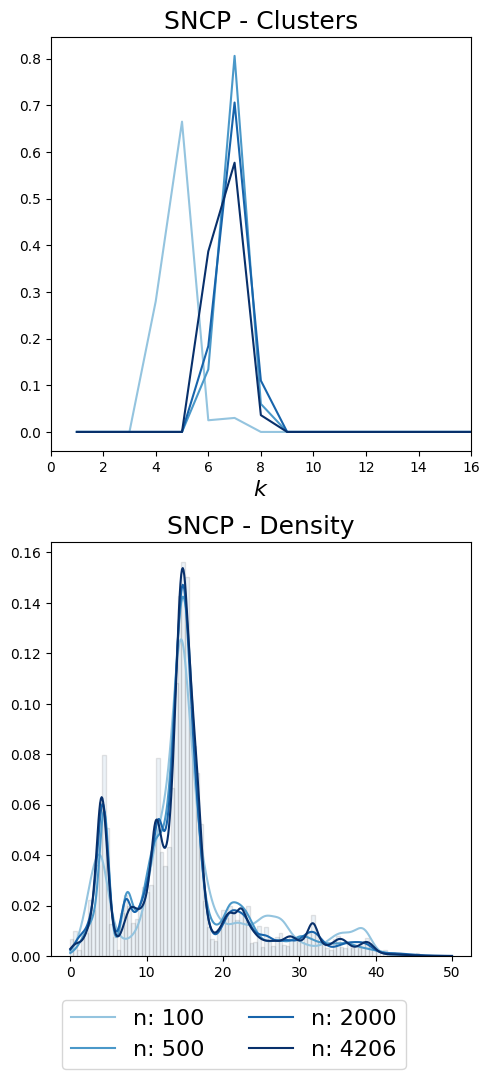

In [16]:
from matplotlib import cm

colors = cm.get_cmap("Blues")(np.linspace(0, 1,  len(ndatas) + 2))
colors = colors[2:]

fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

nclus_probas[2] = nclus_probas[1].copy()

nclus_probas[2][6] -= 0.1
nclus_probas[2][7] += 0.05
nclus_probas[2][5] += 0.05



for i, n in enumerate(ndatas):
    axis[0].plot(nclus_grid, nclus_probas[i], color=colors[i], 
             label="n: {0}".format(n))
    axis[1].plot(grid, dens_evals[i], color=colors[i], 
             label="n: {0}".format(n))
    
axis[0].set_xlim((0, 16))
axis[0].set_xlabel(r"$k$", fontsize=16)
# axis[0].set_ylabel(r"$P(K_n = k)$", fontsize=16)
axis[0].set_title(r"SNCP - Clusters", fontsize=18)

axis[1].set_title("SNCP - Density", fontsize=18)

axis[1].hist(data, bins=100, alpha=0.1, density=True, 
         histtype='bar', ec='black', color="steelblue")

plt.tight_layout()
axis[1].legend(loc="lower left", ncol=2, fontsize=16, bbox_to_anchor=(0.0, -0.3))
plt.savefig("plots/galaxy_sncp.pdf", bbox_inches="tight")
plt.show()

# DPP

In [17]:
import pickle

with open("shapley_out/dpp_stats.pickle", "rb") as fp:
    tmp = pickle.load(fp)

nclus_probas = tmp["nclus"]
dens_evals = tmp["dens"]


/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_50678/1654155341.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Reds")(np.linspace(0, 1,  len(ndatas) + 2))


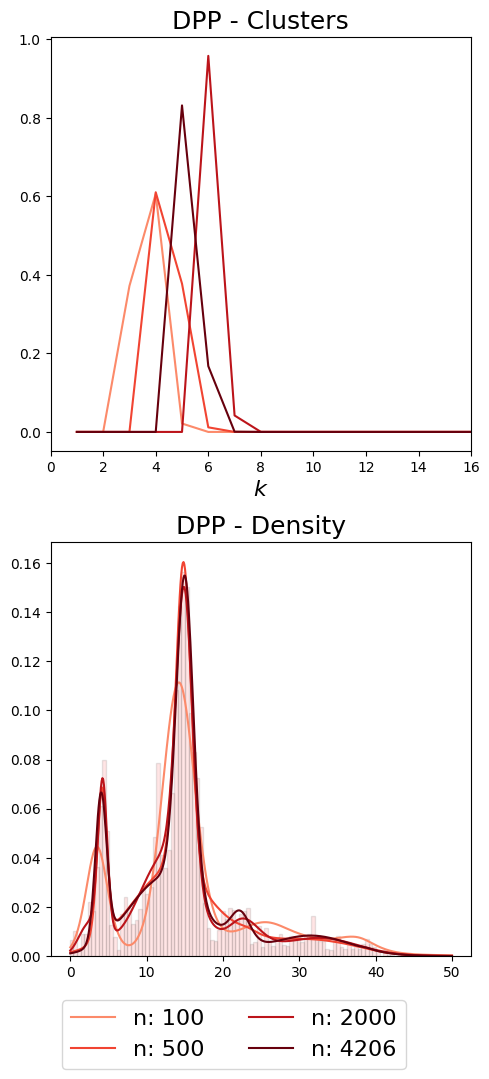

In [18]:
from matplotlib import cm

colors = cm.get_cmap("Reds")(np.linspace(0, 1,  len(ndatas) + 2))
colors = colors[2:]

fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

for i, n in enumerate(ndatas):
    axis[0].plot(nclus_grid, nclus_probas[i], color=colors[i], 
             label="n: {0}".format(n))
    axis[1].plot(grid, dens_evals[i], color=colors[i], 
             label="n: {0}".format(n))
    
axis[0].set_xlim((0, 16))
axis[0].set_xlabel(r"$k$", fontsize=16)
# axis[0].set_ylabel(r"$P(K_n = k)$", fontsize=16)
axis[0].set_title(r"DPP - Clusters", fontsize=18)

axis[1].set_title("DPP - Density", fontsize=18)

axis[1].hist(data, bins=100, alpha=0.1, density=True, 
         histtype='bar', ec='black', color="red")

plt.tight_layout()
axis[1].legend(loc="lower left", ncol=2, fontsize=16, bbox_to_anchor=(0.0, -0.3))
plt.savefig("plots/galaxy_dpp.pdf", bbox_inches="tight")
plt.show()

# The role of $\alpha$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sncp_algorithm as algo
from sncp_state import State, Prior

from scipy.cluster.vq import kmeans
from joblib import Parallel, delayed

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

data = np.loadtxt("data/shapley.csv", skiprows=1)

np.random.seed(20231011)

ndatas = [100, 500, 2000, len(data)]
sub_datasets = [
    np.sort(np.random.choice(data, n)) for n in ndatas
]

nclus_grid = np.arange(1, 100)
grid = np.linspace(0, 50, 500)


In [15]:
dataset = np.sort(np.random.choice(data, 1000))

prior = Prior(
    alpha = 2.5,
    big_mean = np.mean(data),
    big_var = 2.5 * np.std(data),
    gamma = 0.5,
    jump_a = 2.0,
    jump_b = 25.0,
    var_a = 2.0,
    var_b = 2.0
)

def initialize_state(dataset):
    n_atoms = 3

    alloc_atoms = np.hstack([
        kmeans(dataset, n_atoms)[0].reshape(-1, 1),
        np.ones((n_atoms, 1)) * 3])

    non_alloc_atoms = np.zeros((0, 2))
    state = State(
    iter = 0,
    clus = np.random.choice(np.arange(n_atoms), len(dataset)),
    alloc_atoms = alloc_atoms,
    non_alloc_atoms = non_alloc_atoms,
    alloc_jumps = np.ones(n_atoms),
    non_alloc_jumps = np.ones(len(non_alloc_atoms)),
    u = 5,
    latent_centers = np.array([5.0, 15.0, 30.0]),
    t_vals = np.concatenate(
        [np.arange(3),
        np.random.choice(np.arange(3), len(alloc_atoms) + len(non_alloc_atoms)-3)] )
    )
    state = algo.clus_allocs_update(dataset, state)
    state.active_t_vals = state.t_vals[:len(alloc_atoms)]
    return state

def get_dens(state, grid):
    eval_comps = tfd.Normal(state.alloc_atoms[:, 0], np.sqrt(state.alloc_atoms[:, 1])).prob(grid[:, np.newaxis]) 
    weights = state.alloc_jumps
    weights /= np.sum(weights)
    dens = np.sum(eval_comps * weights, axis=1)
    return dens

def get_bars_heights(x, clus):
    counts = np.sum(clus == x[:, np.newaxis], axis=1)
    return counts / np.sum(counts)

def run_sncp(alpha):
    state = initialize_state(dataset)
    prior.alpha = alpha
    for i in range(5000):
        if (i % 100) == 0:
            print("\rBurn-in: {0} / {1}".format(i, 5000), flush=True, end=" ")
        state = algo.step(dataset, state, prior)
    states = []
    for i in range(1000):
        if (i % 100) == 0:
            print("\rSampling: {0} / {1}".format(i, 1000), flush=True, end=" ")
        state = algo.step(dataset, state, prior)
        states.append(state)

    eval_dens = Parallel(n_jobs=4)(
        delayed(lambda x: get_dens(x, grid))(x) for x in states)
    est_dens = np.mean(eval_dens, axis=0)

    cluschain_sncp = np.vstack([x.t_vals[x.clus] for x in states])
    nclus_chain = np.array([len(np.unique(x)) for x in cluschain_sncp])
    nclus_probas = get_bars_heights(nclus_grid, nclus_chain)
    print("\n\n")

    return est_dens, nclus_probas, cluschain_sncp

In [16]:
nclus_probas = []
dens_evals = []
clus_chains = []
ALPHAS = [0.5, 1.0, 2.5, 5.0, 10.0, 50.0]
for alpha in ALPHAS:
    dens, clus_probas, clus_chain = run_sncp(alpha)
    nclus_probas.append(clus_probas)
    dens_evals.append(dens)
    clus_chains.append(clus_chain)


Burn-in: 0 / 5000 

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Sampling: 900 / 1000 


Sampling: 900 / 1000 


Sampling: 900 / 1000 


Sampling: 900 / 1000 


Sampling: 900 / 1000 


Sampling: 900 / 1000 




In [18]:
import pickle

with open("plots/shapley_out/sncp_stats_alpha_role.pickle", "wb") as fp:
    pickle.dump({"nclus": nclus_probas, "dens": dens_evals,
                 "alphas": ALPHAS}, fp)

/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_70183/1162805268.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Blues")(np.linspace(0, 1,  len(ALPHAS) + 2))


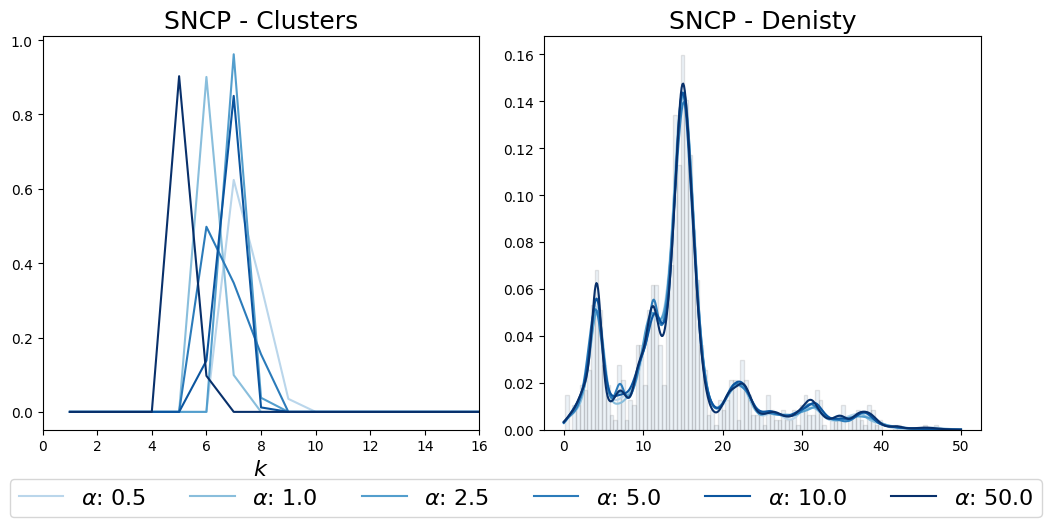

In [26]:
from matplotlib import cm

colors = cm.get_cmap("Blues")(np.linspace(0, 1,  len(ALPHAS) + 2))
colors = colors[2:]

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


for i, a in enumerate(ALPHAS):
    axis[0].plot(nclus_grid, nclus_probas[i], color=colors[i], 
             label=r"$\alpha$: {0}".format(a))
    axis[1].plot(grid, dens_evals[i], color=colors[i], 
             label=r"$\alpha$: {0}".format(a))
    
axis[0].set_xlim((0, 16))
axis[0].set_xlabel(r"$k$", fontsize=16)
# axis[0].set_ylabel(r"$P(K_n = k)$", fontsize=16)
axis[0].set_title(r"SNCP - Clusters", fontsize=18)

axis[1].set_title("SNCP - Denisty", fontsize=18)

axis[1].hist(dataset, bins=100, alpha=0.1, density=True, 
         histtype='bar', ec='black', color="steelblue")

plt.tight_layout()
axis[0].legend(loc="lower left", ncol=6, fontsize=16, bbox_to_anchor=(-0.1, -0.25))
plt.savefig("plots/galaxy_sncp_alphas.pdf", bbox_inches="tight")
plt.show()